### Building a CNN:

In [150]:
import torch
from torch import nn

import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [151]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [152]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [153]:
# Data Loaders turn data into Python iterables
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # Not optimal to shuffle test

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

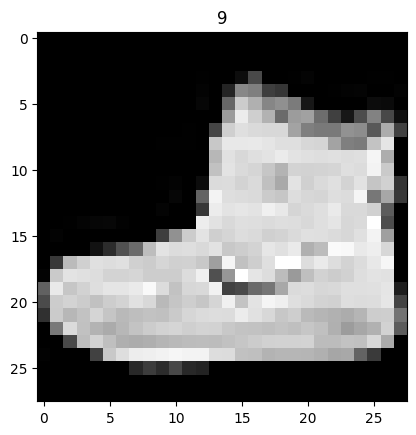

In [154]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(),cmap='gray') # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label)


In [155]:
class FashionMNISTModelV2(nn.Module):

    def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1=nn.Sequential( # Blocks are collections of layers
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), # Establish hyper parameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2=nn.Sequential( # Blocks are collections of layers
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), # Establish hyper parameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x

In [156]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # 1 because we have only one color channel
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

## What is nn.Conv2d()?

Convolves over a matrix of data points. It will add up certain values according to weights and multiply them by a bias to optimize pattern recognition.

- Testing with dummy inputs
- Single layers
- Hidden layers in a sense replaces the color channels

In [157]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
#print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]


In [158]:
torch.manual_seed(42)
# Create a single Conv2d() layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10, # Hidden units
                       kernel_size=(3,3), # Number of datapoints to reduce into a single value, note: 3 = (3,3)
                       stride=1, # Number of datapoints to skip after each operation
                       padding=0 ) # Padding allows matrix to have dimensions divisible by kernel

conv_output = conv_layer(test_image)

conv_output.shape

torch.Size([10, 62, 62])

## What is nn.MaxPool2d()?

Like convolution but more drastic, will simply take the maximum of a certain amount of datapoints to reduce dimension size.

In [159]:
test_image.shape

torch.Size([3, 64, 64])

In [160]:
max_pool_layer=nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image)
print(f'Shape after conv_layer: {test_image_through_conv.shape}')

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f'Shape after both layers: {test_image_through_conv_and_max_pool.shape}')

Shape after conv_layer: torch.Size([10, 62, 62])
Shape after both layers: torch.Size([10, 31, 31])


In [161]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value 

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


In [162]:
image_stretched = image.unsqueeze(dim=0)
print(image_stretched.shape)
output = model_2(image_stretched.to(device))
output.shape


torch.Size([1, 1, 28, 28])


torch.Size([1, 10])

Example of writing individual layers and test tensors

In [163]:
test_1 = torch.randn(size=(1,10,7,7))
flattn = nn.Flatten()
output_1 = flattn(test_1)
output_1.shape

torch.Size([1, 490])

## Let's Train!!

In [164]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

loss_fn=nn.CrossEntropyLoss() # Because multiple classification problem
optimizer= torch.optim.SGD(params=model_2.parameters(),lr=0.1)

In [165]:
def train_step(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer, 
               accuracy_fn, 
               device: torch.device = device):
    """Performs training step with model trying to learn on data_loader."""
    train_loss, train_acc = 0, 0
    model.to(device)

    # Put model into training mode
    model.train()

    # Loop through batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)
        # 1. Forward Pass (outputs raw logits)
        y_pred = model(X)
        # 2. Calculate the loss and accuracy per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step (update model's parameters once per batch)
        optimizer.step()
    
    # Divide total train acc and loss by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%')

def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device = device):
    """Performs testing step with model trying to learn on data_loader."""
    test_loss, test_acc = 0, 0
    model.to(device)

    # Put the model in eval mode
    model.eval()

    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Put data on target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1)) # go from logits to prediction labels
        
        # Adjust metric and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} | Train acc: {test_acc:.2f}%')

In [166]:
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints time difference"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                                end=train_time_end_model_2,
                                                device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59109 | Train acc: 78.50%


 33%|███▎      | 1/3 [00:22<00:45, 22.78s/it]

Test loss: 0.39324 | Train acc: 85.90%
Epoch: 1
---------
Train loss: 0.36446 | Train acc: 86.84%


 67%|██████▋   | 2/3 [00:45<00:22, 22.64s/it]

Test loss: 0.34919 | Train acc: 87.21%
Epoch: 2
---------
Train loss: 0.32720 | Train acc: 88.09%


100%|██████████| 3/3 [01:08<00:00, 22.74s/it]

Test loss: 0.32944 | Train acc: 88.04%
Train time on cpu: 68.213 seconds


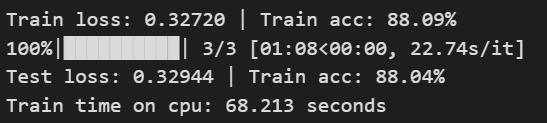

- 22.64s/it means that every epoch takes roughly 22 seconds.

In [169]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn, 
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [170]:
model_2_results=eval_model(model=model_2,
                           data_loader=test_dataloader,
                           loss_fn=loss_fn,
                           accuracy_fn=accuracy_fn,
                           device=device)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3294386565685272,
 'model_acc': 88.03913738019169}

**Success!**

## Using our model to make predictions

In [172]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations. Matplotlib does not work with data on GPU.
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [173]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k =9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

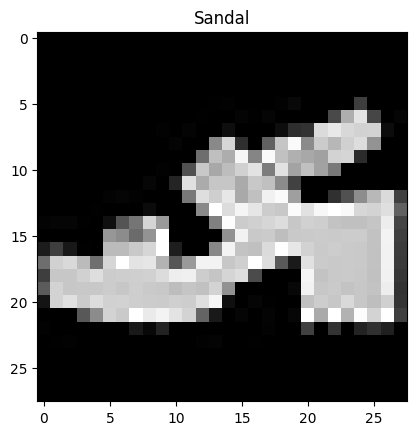

In [175]:
plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])

In [ ]:
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

pred_probs[:2] # Prediction probabilities

tensor([[1.5287e-07, 3.2200e-09, 1.1364e-08, 5.9895e-08, 7.9744e-10, 9.9994e-01,
         1.5622e-07, 1.5245e-05, 1.1493e-05, 3.0917e-05],
        [6.5432e-02, 4.6620e-01, 3.8448e-03, 2.1406e-01, 7.8372e-02, 3.4075e-05,
         1.7006e-01, 8.6039e-04, 1.0280e-03, 1.1147e-04]])

In [180]:
pred_classes =  pred_probs.argmax(dim=1)
print(f'prediction labels: {pred_classes}')
print(f'actual labels: {test_labels}')

prediction labels: tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])
actual labels: [5, 1, 7, 4, 3, 0, 4, 7, 1]


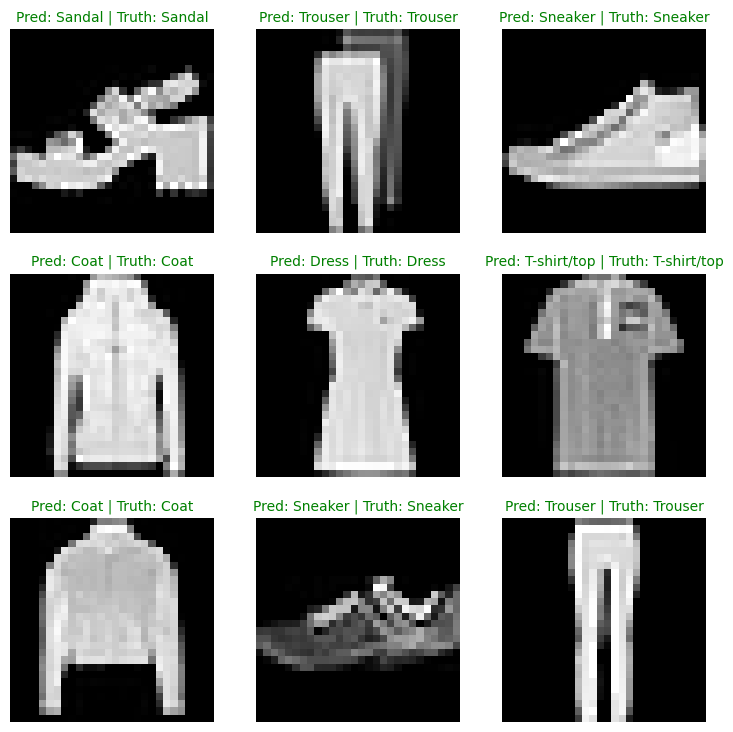

In [181]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);